Import libraries including custom `ata_rfsoc_fengine`

In [16]:
import numpy as np
import scipy.signal
from matplotlib import pyplot as plt
%matplotlib inline
plt.rcParams['figure.figsize'] = [12, 6]
from ata_snap import ata_rfsoc_fengine

Instantiate a control interface to the first ntennas DSP pipeline on a board. Mostly we'll just use the underlying FPGA connection, since we want to use all ADC channels.

In [6]:
FPGA_HOST = 'rfsoc3-ctrl-1'
FPG_FILE = '/home/jackh/src/ata_rfsoc/zrf_spec_4ant/outputs/zrf_spec_4ant_2021-06-14_1301.fpg'
SAMPLE_RATE_MHZ = 2048.
f = ata_rfsoc_fengine.AtaRfsocFengine(FPGA_HOST)
f.fpga.get_system_information(FPG_FILE)

Assume the FPGA is already programmed but may not be properly configured. Carry out basic initialization.

In [3]:
# Set the accumulation for the firmware spectrometer
f.set_accumulation_length(8*5*1024) # 40960 spectra; 163.84 ms
# Reset the sync pulse logic
f.sync_arm(manual_trigger=True) # works with or without PPS

1624278554

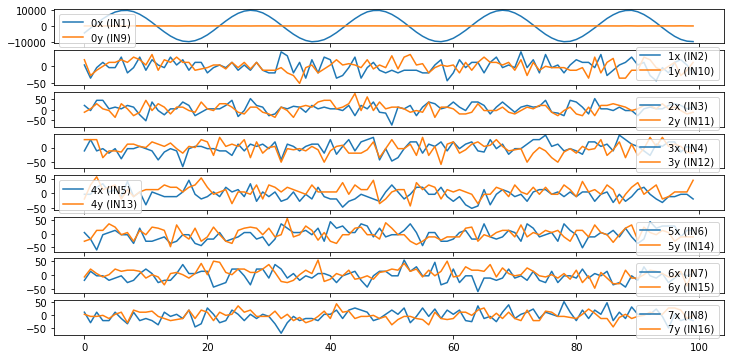

In [13]:
ata_rfsoc_fengine.adc_plot_all(f)
# X-axis: Sample number
# Y-axis: ADC value

All channels 50-ohm terminated except IN1 (antenna 0, X-pol), driven with a 100MHz sine wave at 0 dBm (? Alex, confirm).
Spectrum analyzer for the input signal: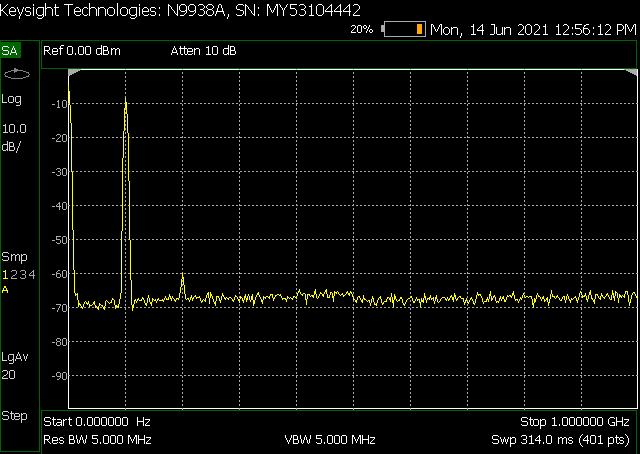

Plotting the driven channel by taking 16 16384-sample snapshots, performing an FFT and averaging power:

In [66]:
spec_software = ata_rfsoc_fengine.adc_get_spec(f, 0, 0, 16)

Number of channels: 4097
Peak: 48.00 MHz; -76.04 dB
Peak: 100.00 MHz; 0.00 dB
Peak: 200.00 MHz; -53.42 dB
Peak: 212.00 MHz; -75.32 dB
Peak: 300.00 MHz; -65.82 dB
Peak: 500.00 MHz; -75.56 dB
Peak: 512.00 MHz; -75.00 dB
Peak: 724.00 MHz; -76.01 dB
Peak: 812.00 MHz; -74.02 dB


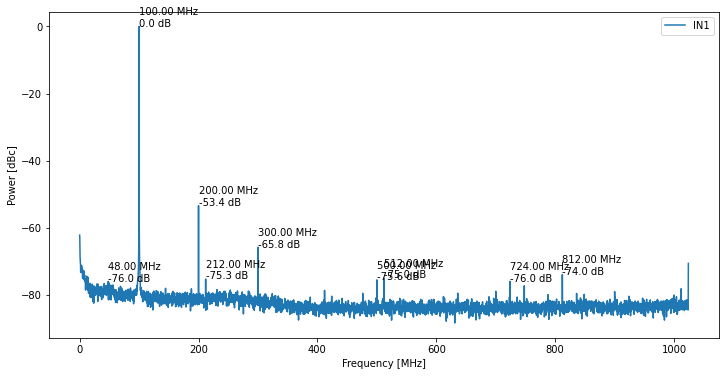

In [151]:
# Nomalize to max
spec_software /= spec_software.max()
spec_db = 10*np.log10(spec_software)
mean_power = np.median(spec_software)
n_chans = spec_software.shape[0]
print("Number of channels: %d" % n_chans)
freq_axis = np.linspace(0, SAMPLE_RATE_MHZ / 2., n_chans)
peaks, props = scipy.signal.find_peaks(spec_software, height=5*mean_power)
#print("Peaks found: %d" % peaks.shape[0])
plt.plot(freq_axis, spec_db, label="IN1")
plt.xlabel("Frequency [MHz]")
plt.ylabel("Power [dBc]")
plt.legend()

for p in peaks:
    # High pass filter peaks
    if freq_axis[p] < 15.:
        continue
    label = "%.2f MHz\n%.1f dB" % (freq_axis[p], spec_db[p])
    pos = (freq_axis[p], spec_db[p])
    plt.annotate(label, pos)
    print("Peak: %.2f MHz; %.2f dB" % (freq_axis[p], spec_db[p]))

RFSoC measures the first spur -53 dB down from the peak, broadly in line with spectrum analyzer. All other peaks are below the spectrum analyzer noise floor

Next, grab a similar spectrum using the firmware channelizer. Note that this is not just an FFT, and uses a 4-tap (Hamming-windowed) PFB. Firmware generates 4096 channels.

In [71]:
spec_firmware, _ = f.spec_read(mode='auto', flush=True, normalize=True)

Number of channels: 4096
Peak: 100.00 MHz; 0.00 dB
Peak: 200.00 MHz; -53.39 dB
Peak: 212.00 MHz; -74.00 dB
Peak: 300.00 MHz; -66.04 dB
Peak: 500.00 MHz; -75.00 dB
Peak: 512.00 MHz; -71.18 dB
Peak: 812.00 MHz; -73.90 dB


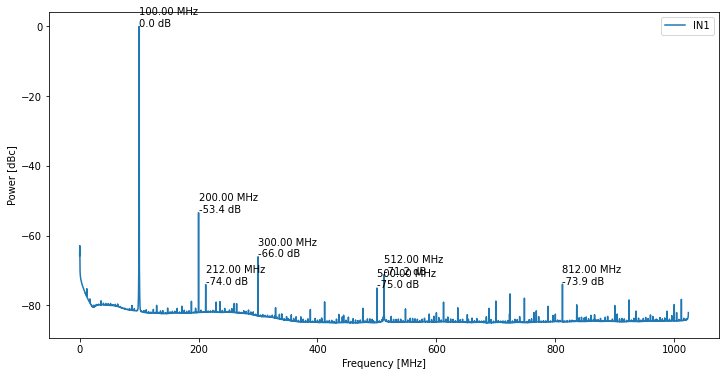

In [150]:
# Nomalize to max
spec_firmware /= spec_firmware.max()
spec_db = 10*np.log10(spec_firmware)
med_power = np.median(spec_firmware)
n_chans = spec_firmware.shape[0]
print("Number of channels: %d" % n_chans)
# Firmware throws away nquist bin. Deal with that here
freq_axis = np.linspace(0, SAMPLE_RATE_MHZ / 2., n_chans+1)[0:-1]
peaks, props = scipy.signal.find_peaks(spec_firmware, height=7*med_power)
#print("Peaks found: %d" % peaks.shape[0])
plt.plot(freq_axis, spec_db, label="IN1")
plt.xlabel("Frequency [MHz]")
plt.ylabel("Power [dBc]")
plt.legend()

for p in peaks:
    # High pass filter peaks
    if freq_axis[p] < 15.:
        continue
    label = "%.2f MHz\n%.1f dB" % (freq_axis[p], spec_db[p])
    pos = (freq_axis[p], spec_db[p])
    plt.annotate(label, pos)
    print("Peak: %.2f MHz; %.2f dB" % (freq_axis[p], spec_db[p]))

Encouragingly, firmware and software spectra look similar. Examining the difference:

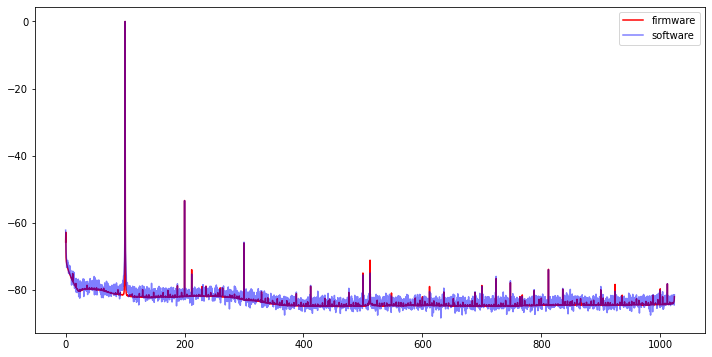

In [101]:
spec_db_sw = 10*np.log10(spec_software)[0:-1] # Dump the nyquist channel
spec_db_fw = 10*np.log10(spec_firmware)
plt.plot(freq_axis, spec_db_fw, 'r', label='firmware')
plt.plot(freq_axis, spec_db_sw, 'b-', alpha=0.5, label='software')
plt.legend()

For cross-talk tests, initially the software FFT is used, since this provides access to all of the RFSoC channels

In [143]:
specs = np.zeros([16, 4097])
specs_db = np.zeros([16, 4097])
for ant in range(8):
    for pn, pol in enumerate(['x', 'y']):
        this_input = ant + 8*pn
        print("Capturing input %d" % this_input)
        specs[this_input] = ata_rfsoc_fengine.adc_get_spec(f, ant, pn, 128)
        specs_db[this_input] = 10*np.log10(specs[this_input])

Capturing input 0
Capturing input 8
Capturing input 1
Capturing input 9
Capturing input 2
Capturing input 10
Capturing input 3
Capturing input 11
Capturing input 4
Capturing input 12
Capturing input 5
Capturing input 13
Capturing input 6
Capturing input 14
Capturing input 7
Capturing input 15


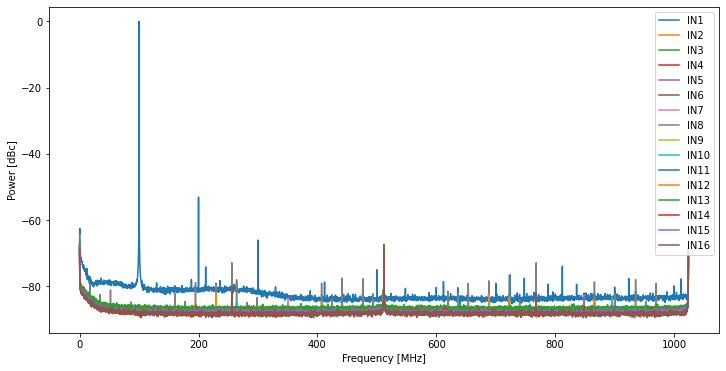

In [147]:
freq_axis = np.linspace(0, SAMPLE_RATE_MHZ / 2., n_chans+1)
db_ref = specs_db[0].max()
for sn, spec in enumerate(specs_db):
    plt.plot(freq_axis, spec - db_ref, label='IN%d' % (sn+1))
plt.xlabel('Frequency [MHz]')
plt.ylabel('Power [dBc]')
plt.legend()

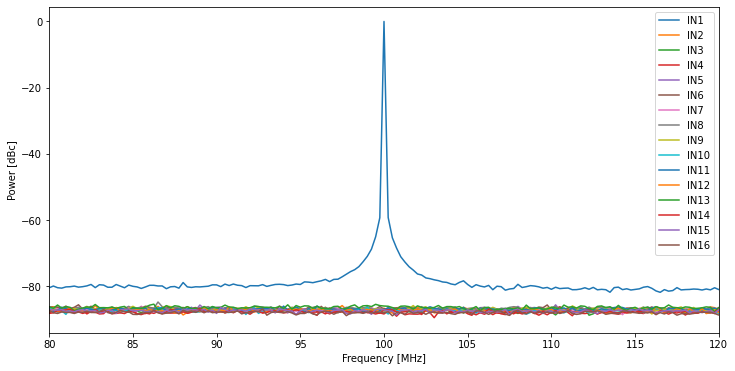

In [148]:
for sn, spec in enumerate(specs_db):
    plt.plot(freq_axis, spec - db_ref, label='IN%d' % (sn+1))
plt.xlim(80,120)
plt.xlabel('Frequency [MHz]')
plt.ylabel('Power [dBc]')
plt.legend()

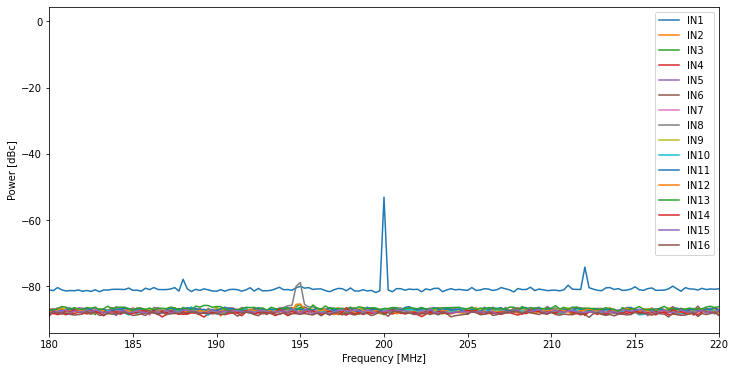

In [149]:
for sn, spec in enumerate(specs_db):
    plt.plot(freq_axis, spec - db_ref, label='IN%d' % (sn+1))
plt.xlim(180,220)
plt.xlabel('Frequency [MHz]')
plt.ylabel('Power [dBc]')
plt.legend()

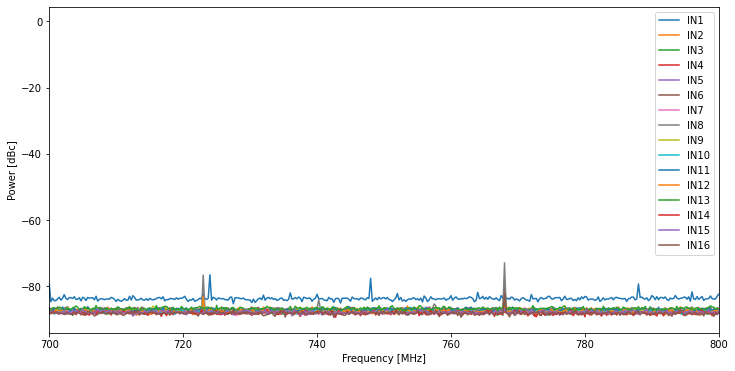

In [152]:
for sn, spec in enumerate(specs_db):
    plt.plot(freq_axis, spec - db_ref, label='IN%d' % (sn+1))
plt.xlim(700,800)
plt.xlabel('Frequency [MHz]')
plt.ylabel('Power [dBc]')
plt.legend()

Try the firmware accumulators to check IN0 / IN1 cross talk with a long (163.84 ms integration)

In [156]:
f1 = ata_rfsoc_fengine.AtaRfsocFengine(FPGA_HOST, pipeline_id=1)
f1.fpga.get_system_information(FPG_FILE)
# Set the accumulation for the firmware spectrometer
f1.set_accumulation_length(8*5*1024) # 40960 spectra; 163.84 ms

In [174]:
x1, y1 = f1.spec_read(mode='auto', flush=True, normalize=True)
x0, y0 = f.spec_read(mode='auto', flush=True, normalize=True)
x1_db = 10*np.log10(x1)
x0_db = 10*np.log10(x0)

(-100.0, -80.0)

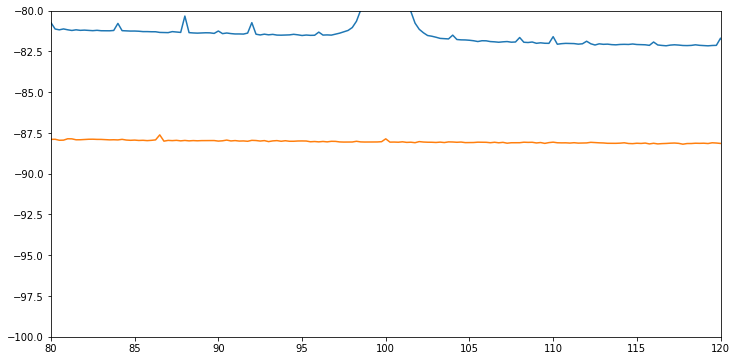

In [177]:
n_chans = 4096
freq_axis = np.linspace(0, SAMPLE_RATE_MHZ / 2., n_chans+1)[0:-1]
plt.plot(freq_axis, x0_db - x0_db.max(), label='IN0')
plt.plot(freq_axis, x1_db - x0_db.max(), label='IN1')
plt.xlim(80,120)
plt.ylim(-100, -80)